In [1]:
import sys
sys.path += [".."]

import smbh
import numpy as np
import matplotlib.pyplot as plt

import sympy as spy
spy.init_printing()

from IPython.display import display
# %matplotlib

# Gammas

In [2]:
def legendre(f, degree):
#     global omega
#     f = spy.lambdify(omega, expression)
    roots, weights = np.polynomial.legendre.leggauss(degree)
    le = f(0.5 * roots + 0.5)
    return 0.5 * sum(le * weights)

def laguerre(f, degree):
#     global tau
#     f = spy.lambdify(tau, expression)
    roots, weights = np.polynomial.laguerre.laggauss(degree)
    la = f(roots)
    return sum(la * weights)

In [3]:
G, tau, omega, gamma = spy.symbols(r'G \tau \omega \gamma', real = True, positive = True)
m, x, y, z, a_1, a_2, a_3, phi_1, phi_2, phi_3 = spy.symbols("m x y z a_1 a_2 a_3 \phi_1 \phi_2 \phi_3",                                                        real = True, positive = True)

m_int = [i ** 2 / (a ** 2 + tau) for (i, a) in zip([x, y, z], [a_1, a_2, a_3])]
m_int = spy.sqrt(a_1 ** 2 * sum(m_int))

phi_x = x / (spy.sqrt(tau + a_1 ** 2) ** 3 * spy.sqrt(tau + a_2 ** 2) * spy.sqrt(tau + a_3 ** 2))
phi_y = y / (spy.sqrt(tau + a_2 ** 2) ** 3 * spy.sqrt(tau + a_1 ** 2) * spy.sqrt(tau + a_3 ** 2))
phi_z = z / (spy.sqrt(tau + a_3 ** 2) ** 3 * spy.sqrt(tau + a_1 ** 2) * spy.sqrt(tau + a_2 ** 2))

In [4]:
t = tau ** gamma / (1 + tau ** gamma)
eq = spy.Eq(t, omega)

s0 = spy.solve(eq, tau)[0]
diff = s0.diff(omega).simplify()

In [5]:
rho_0, R_s = spy.symbols(r"\rho_0 R_s", real = True, positive = True)
M_s, r_s = spy.symbols(r"M_s \mathcal{R_s}", real = True, positive = True)

r_0 = spy.symbols("r_0", real = True, positive = True)
n = spy.symbols("n", real = True, positive = False)

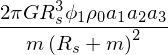

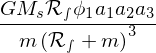

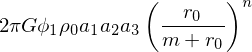

In [6]:
a_nfw = 2 * spy.pi * G * R_s ** 3 * rho_0 * a_1 * a_2 * a_3 * phi_1 / (m * (R_s + m)**2)
a_s =  G * M_s * r_s * a_1 * a_2 * a_3 * phi_1 / (m * (r_s + m)**3)
a_g = 2 * spy.pi * G * rho_0 * a_1 * a_2 * a_3 * (r_0 / (r_0 + m)) ** n * phi_1
display(a_nfw)
display(a_s)
display(a_g)

In [7]:
r = 1
pos = [r, 0, 0]
axis = [1, 1, 1]
smbh.setTriaxalCoeffs(* axis)

const = [(phi_1, phi_x), (m, m_int), (x, pos[0]), (y, pos[1]), (z, pos[2]),
         (a_1, axis[0]), (a_2, axis[1]), (a_3, axis[2]),
        (G, smbh.G)]

c_nfw = [(R_s, 0.172493), (rho_0, 16167.089408)]
c_s = [(M_s, 1.56), (r_s, 0.002858)]
c_g = [(r_0, 1e-3), (n, 2.2), (rho_0, 54406524.177647)]

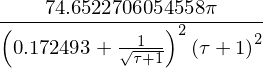

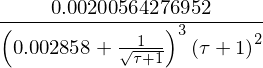

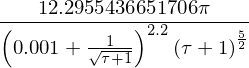

In [8]:
f_nfw = a_nfw.subs(const + c_nfw)
f_s = a_s.subs(const + c_s)
f_g = a_g.subs(const + c_g)

display(f_nfw)
display(f_s)
display(f_g)

In [9]:
acs = [f_nfw, f_s, f_g]
values = [smbh.darkMatterMass(r), smbh.stellarMassHernquist(r), smbh.gasMass(r)]

values = smbh.G * np.array(values) / r ** 2
labels = ['Dark matter', 'Stars', 'Gas']

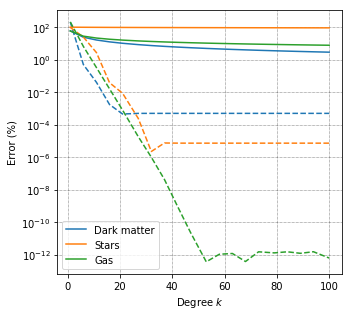

In [10]:
degrees = np.linspace(1, 100, 20).astype(int)

fig, ax = plt.subplots(figsize = (5, 4.5))

for i in range(3):
    val = values[i]
    a = acs[i] * spy.exp(tau)
    f = spy.lambdify(tau, a)
    v = [laguerre(f, d) for d in degrees]
    v = 100 * abs(v - val) / val
    c = ax.plot(degrees, v, label = labels[i])[0].get_color()
    
    a = (acs[i] * diff).subs([(tau, s0), (gamma, 0.2)])
    f = spy.lambdify(omega, a)
    v = [legendre(f, d) for d in degrees]
    v = 100 * abs(v - val) / val
    ax.plot(degrees, v, '--' ,c = c)
    
ax.set_yscale('log')

ax.set_xlabel(r'Degree $k$')
ax.set_ylabel('Error (%)')
ax.legend()

ax.grid()

fig.tight_layout()

fig.savefig("scheme_error.png", dpi = 300)

In [11]:
gammas = np.logspace(-3, 2, 1000)
results = np.zeros((len(gammas), 3))

In [12]:
smbh.setTriaxalCoeffs(1, 1, 1)

for i, gamma in enumerate(gammas):
    results[i] = [smbh.triaxial_gravDM(1, 0, 0, gamma)[0], 
                  smbh.triaxial_gravS(1, 0, 0, gamma)[0],
                  smbh.triaxial_gravG(1, 0, 0, gamma)[0]]
    
references = np.array([smbh.darkMatterMass(1), smbh.stellarMassHernquist(1), smbh.gasMass(1)])
references *= smbh.G

for i in range(3):
    results[:, i] = 100 * abs(results[:, i] - references[i]) / references[i]

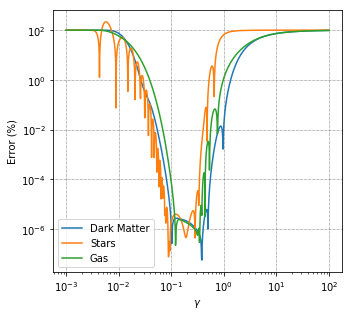

In [13]:
fig, ax = plt.subplots(figsize = (5, 4.5))

labels = ["Dark Matter", "Stars", "Gas"]

for i in range(3):
    ax.plot(gammas, results[:, i], label = labels[i])

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Error (%)')
ax.legend()
ax.grid()

fig.tight_layout()

fig.savefig("gamma_error.png", dpi = 300)